## Notebook for the transfer annotation of heart immune cells to 3K PBMCs using LogReg 

- Carlos Talavera-López Ph.D - WSI
- This notebook was originally developed by `kp9`, and I modified for my research.
- v200624

### Load required modules

In [1]:
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import scanpy as sc

### Set up working environment 

In [56]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 200, color_map = 'inferno_r')

scanpy==1.4.5.1 anndata==0.7.3 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.2 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import multiprocessing
print(multiprocessing.cpu_count())

24


### Load the dataset to be annotated

- Read in the heart immune and replace it in the _tissues_ object

In [5]:
heart = sc.read_h5ad('/home/jovyan/experiments/2-subpopulations/4-immune/heart_immmune_scGen_raw_ctl200609_annotated.h5ad')
heart.shape

(40868, 33538)

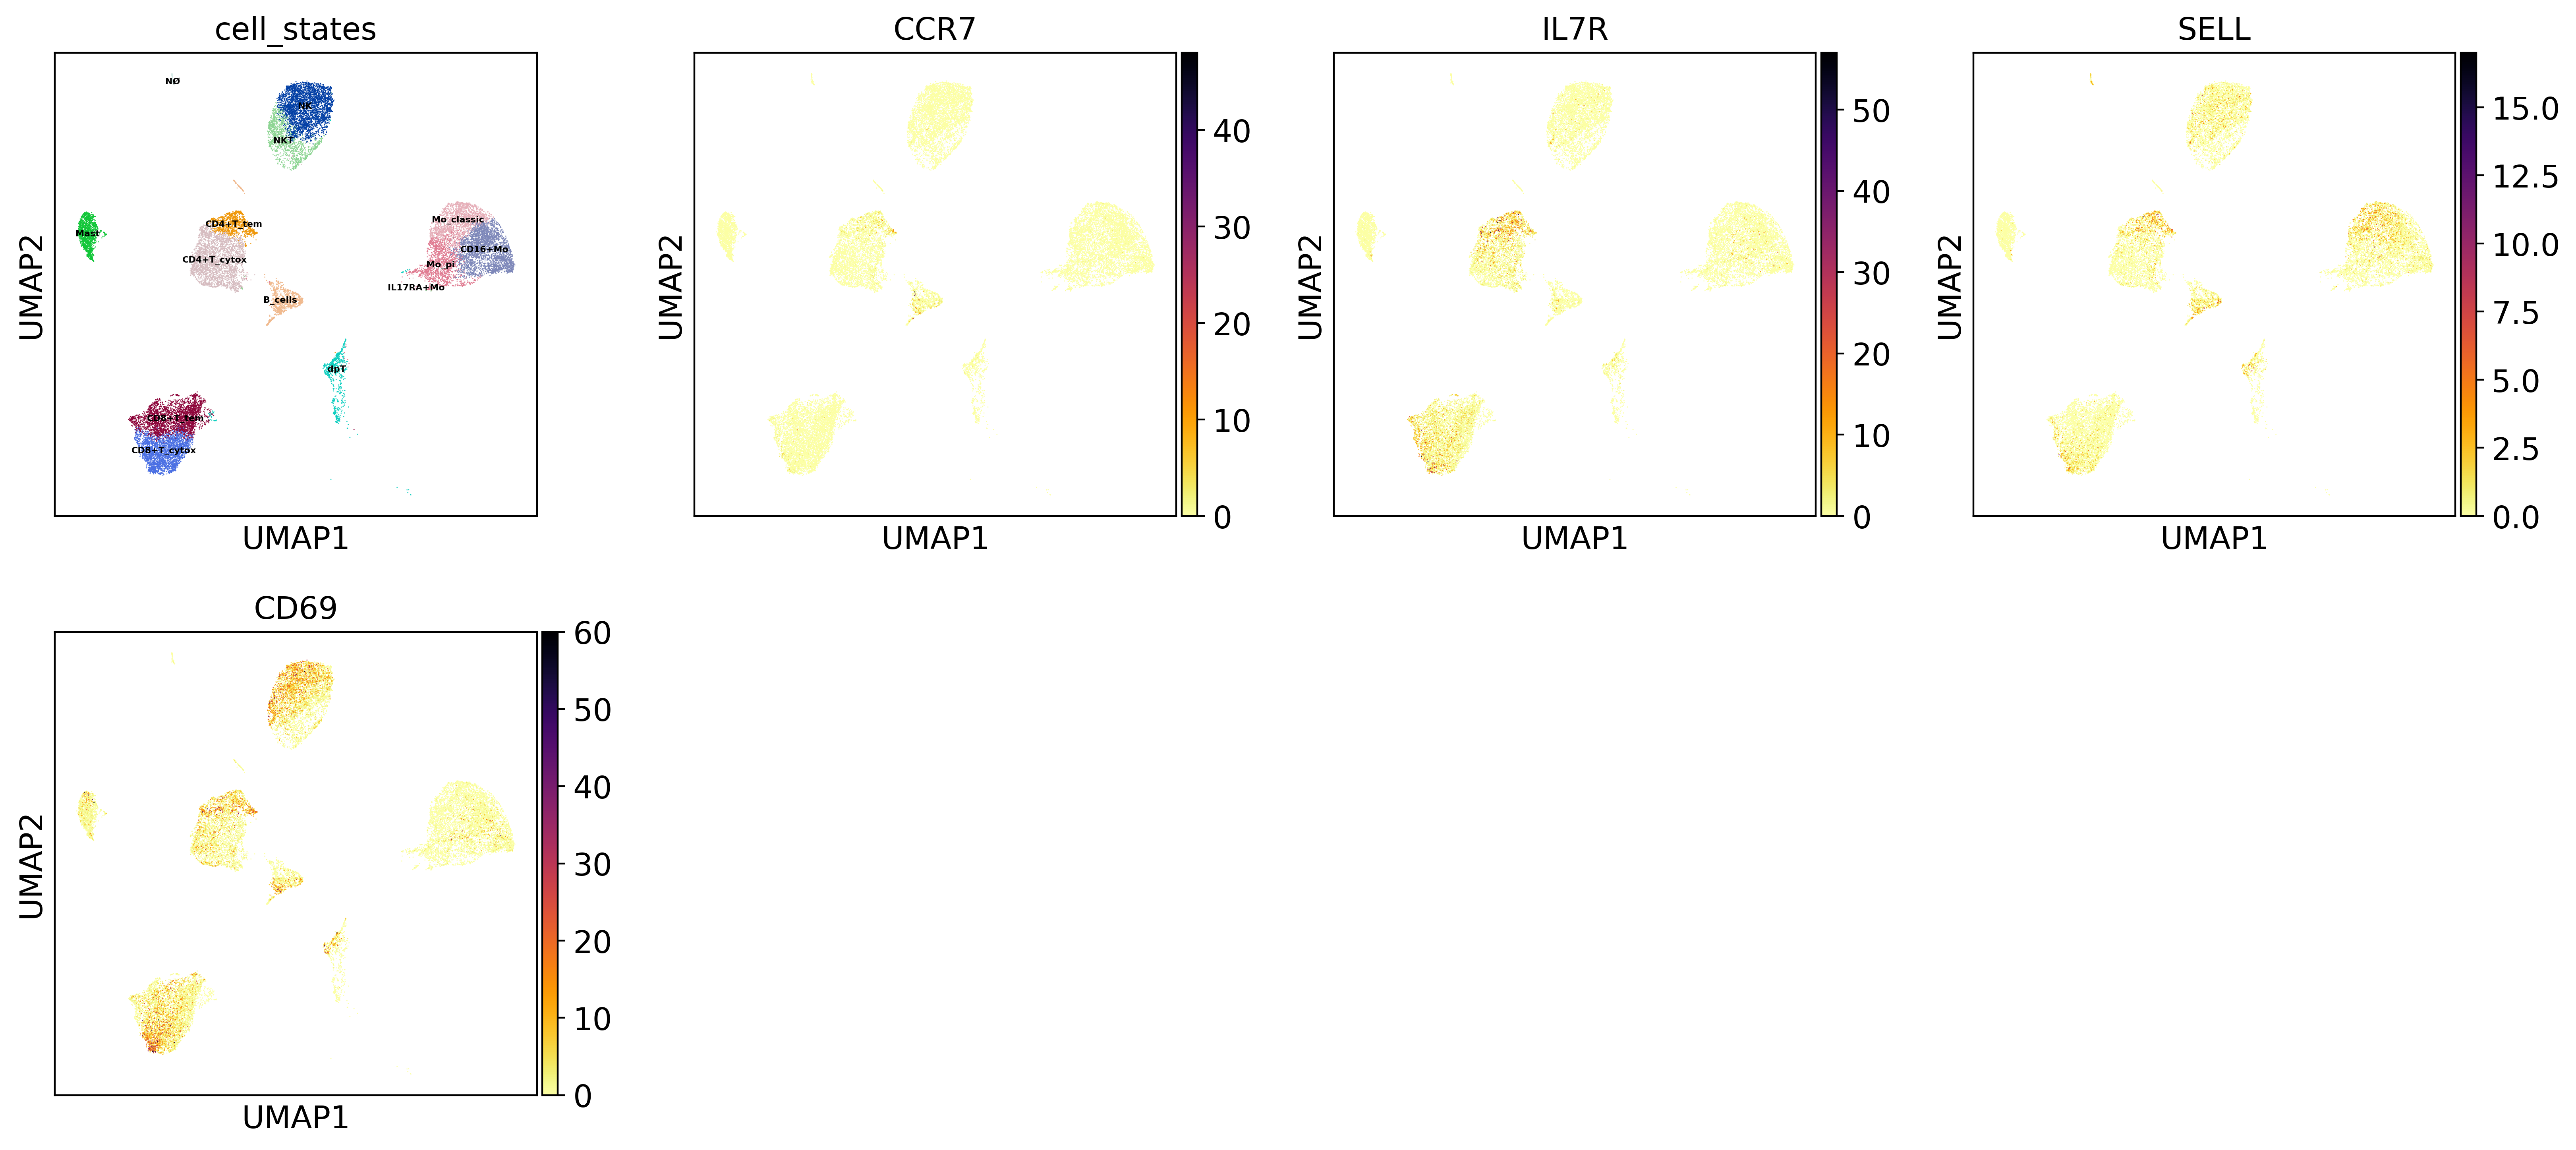

In [79]:
sc.pl.umap(heart, color = ['cell_states', 'CCR7', 'IL7R', 'SELL', 'CD69'], size = 1, legend_loc = 'on data', legend_fontsize = 4)

In [ ]:
sc.pl.umap(heart, color = ['cell_states', 'ITGAE', 'ITGA1', 'CD69'], frameon = False, size = 1, legend_loc = 'on data', legend_fontsize = 6)

In [6]:
blood = sc.read_10x_mtx("/home/jovyan/data/refseq/10X_PBMC/filtered_feature_bc_matrix/", cache = True)
blood.shape

... reading from cache file cache/home-jovyan-data-refseq-10X_PBMC-filtered_feature_bc_matrix-matrix.h5ad


(11769, 33538)

In [7]:
blood.X.data[:5]

array([1., 1., 1., 2., 1.], dtype=float32)

In [8]:
blood

AnnData object with n_obs × n_vars = 11769 × 33538
    var: 'gene_ids', 'feature_types'

### Cluster and annotate the blood dataset

In [9]:
sc.pp.filter_cells(blood, min_genes = 500)
sc.pp.filter_cells(blood, min_counts = 1000)
blood

filtered out 491 cells that have less than 500 genes expressed
filtered out 20 cells that have less than 1000 counts


AnnData object with n_obs × n_vars = 11258 × 33538
    obs: 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types'

In [10]:
blood.var['mt'] = blood.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(blood, qc_vars=['mt'], percent_top=None, inplace=True)

... storing 'feature_types' as categorical


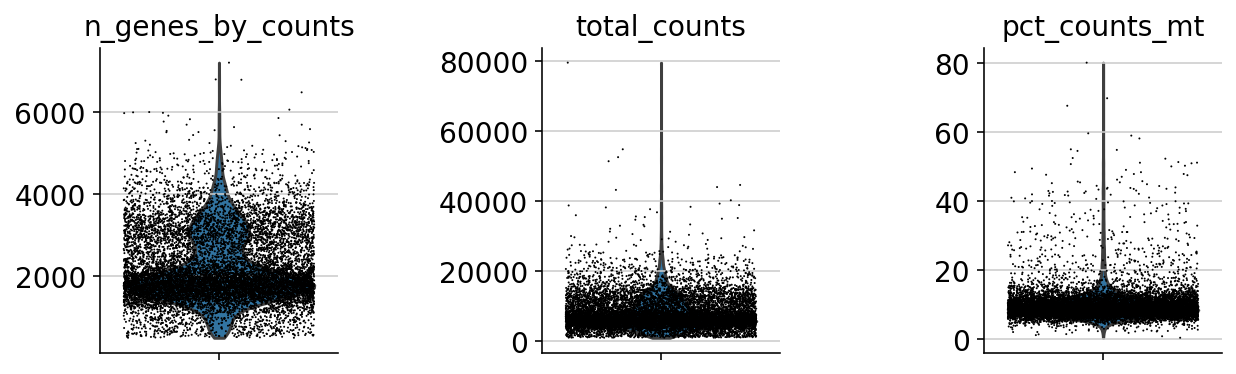

In [11]:
sc.pl.violin(blood, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [12]:
blood = blood[blood.obs.n_genes_by_counts < 2500, :]
blood = blood[blood.obs.pct_counts_mt < 10, :]
blood

View of AnnData object with n_obs × n_vars = 4690 × 33538
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [15]:
sc.pp.normalize_total(blood, target_sum = 1e4)
sc.pp.log1p(blood)
sc.pp.highly_variable_genes(blood)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [16]:
blood.raw = blood.copy()
blood = blood[:, blood.var.highly_variable]
sc.pp.regress_out(blood, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(blood, max_value=10)
sc.tl.pca(blood, svd_solver='arpack')
sc.pp.neighbors(blood, n_neighbors=10, n_pcs=40)
sc.tl.umap(blood)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/opt/conda/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


    finished (0:00:35)
computing PCA with n_comps = 50
    on highly variable genes


/opt/conda/lib/python3.7/site-packages/scanpy/_utils.py:341: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:


    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 40


/opt/conda/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:104: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing UMAP


/opt/conda/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/opt/conda/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/opt/conda/lib/python3.7/site-packages/scanpy/tools/_umap.py:144: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


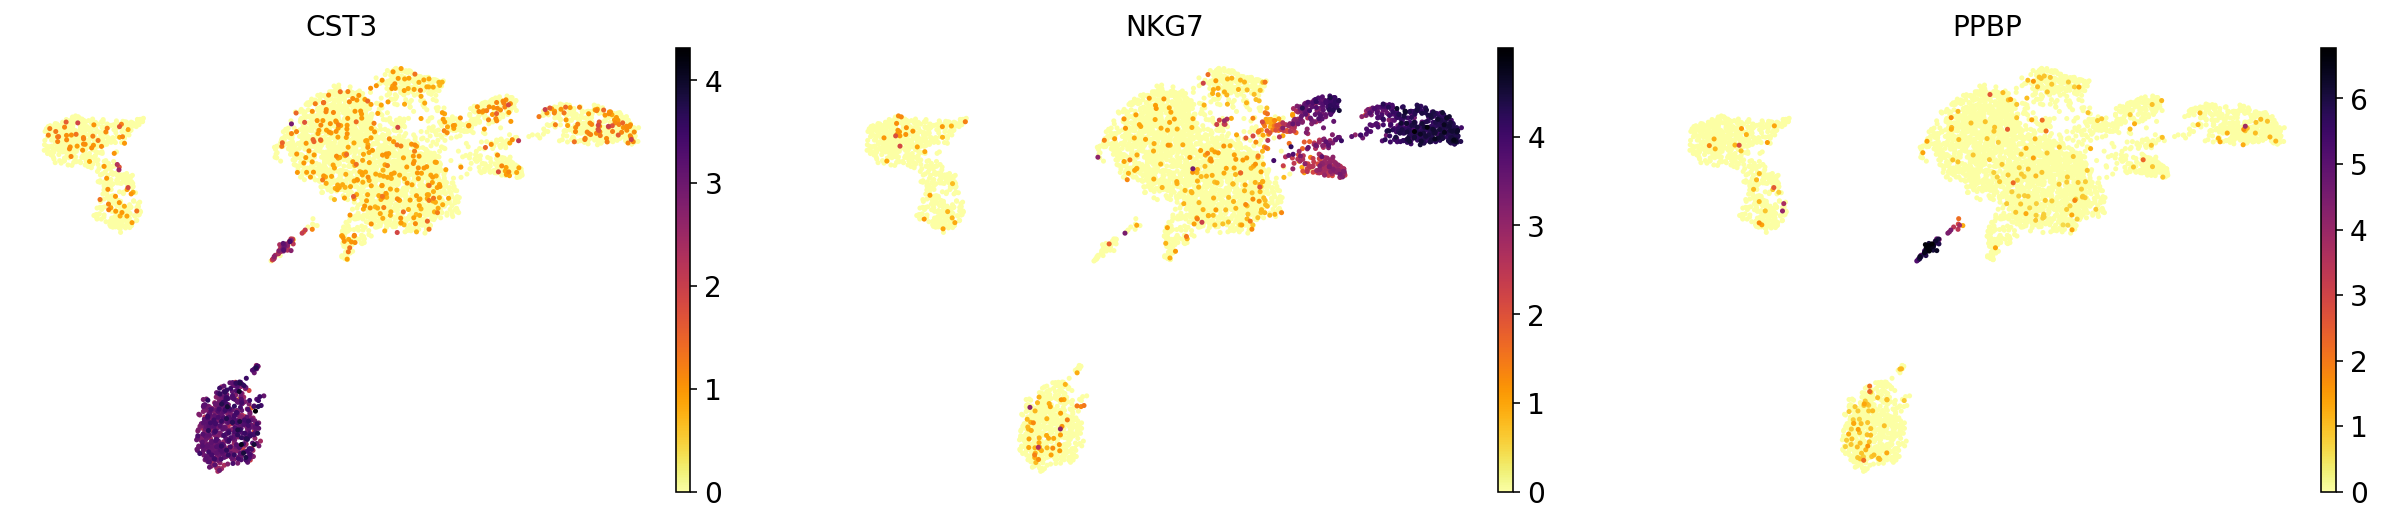

In [17]:
sc.pl.umap(blood, color=['CST3', 'NKG7', 'PPBP'], frameon = False)

running Leiden clustering


/opt/conda/lib/python3.7/site-packages/scanpy/tools/_leiden.py:112: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']


    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


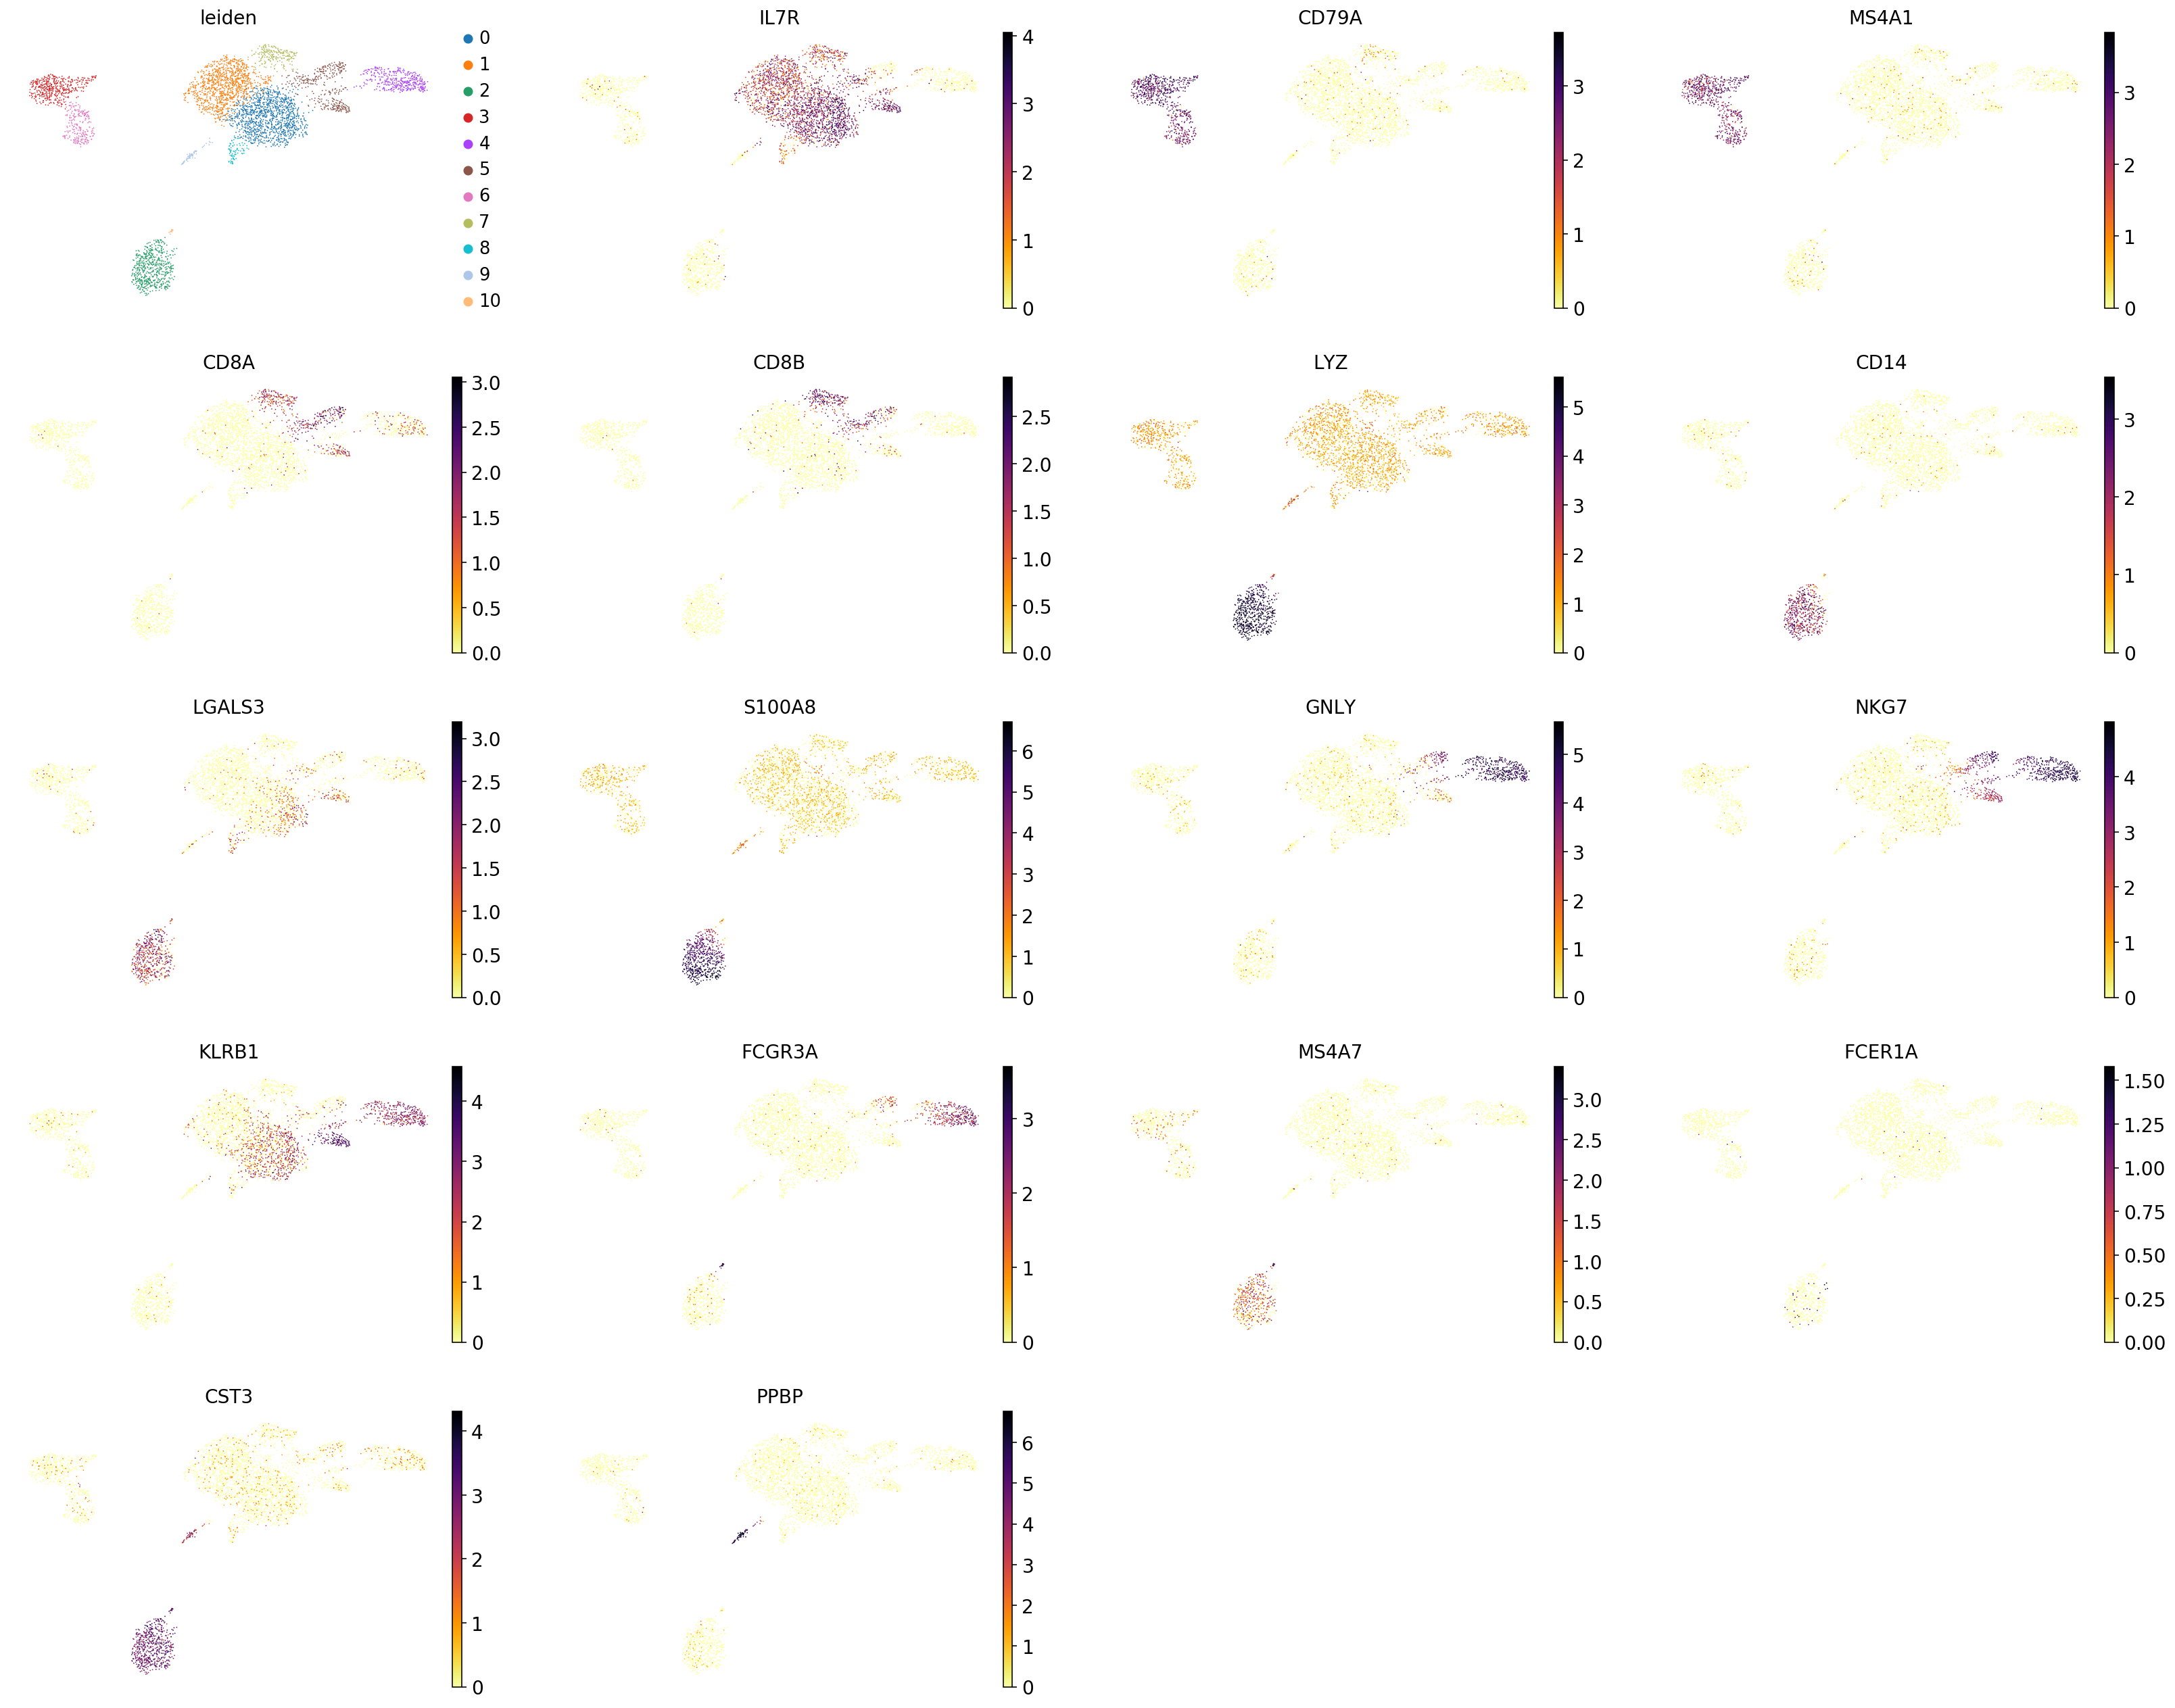

In [18]:
sc.tl.leiden(blood, resolution = 0.5)
sc.pl.umap(blood, color=['leiden', 'IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP'], frameon = False, size = 3)

In [19]:
blood.obs['leiden'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype='object')

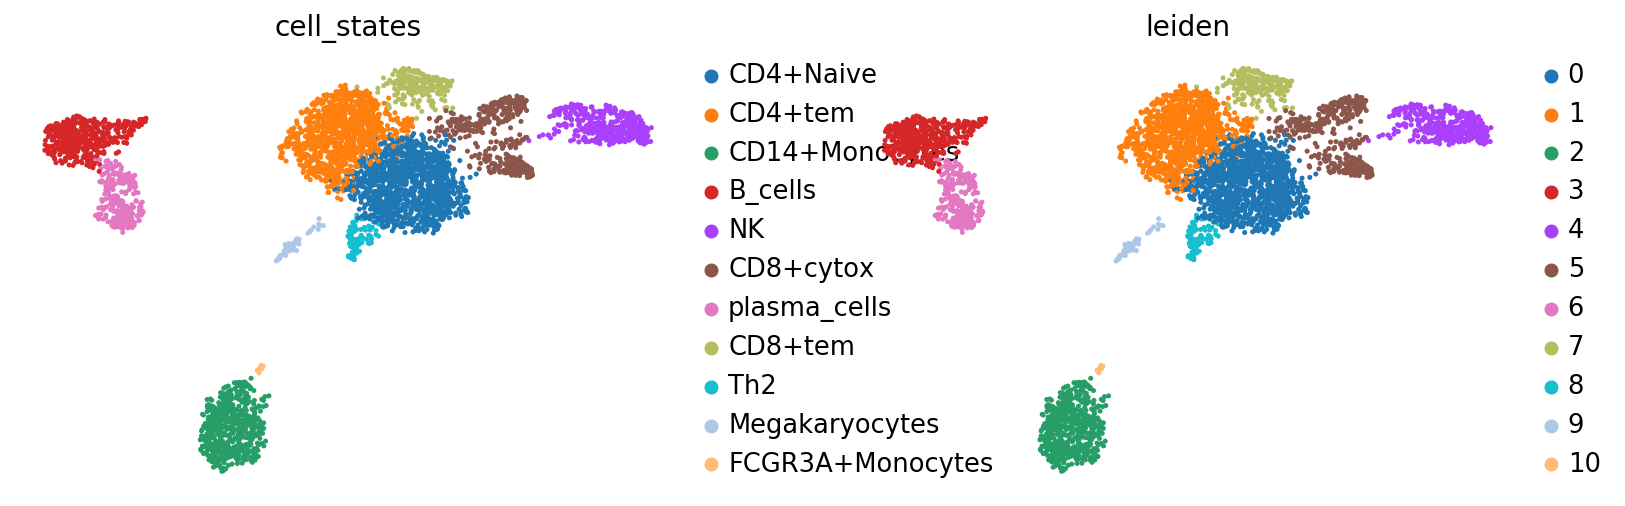

In [20]:
blood.obs['cell_states'] = blood.obs['leiden']
blood.obs['cell_states'].cat.categories = ['CD4+Naive', 'CD4+tem', 'CD14+Monocytes', 'B_cells', 'NK', 'CD8+cytox', 'plasma_cells', 'CD8+tem', 'Th2', 'Megakaryocytes', 'FCGR3A+Monocytes']
sc.pl.umap(blood, color=['cell_states', 'leiden'], frameon = False)

In [21]:
blood.obs['cell_states'].cat.categories

Index(['CD4+Naive', 'CD4+tem', 'CD14+Monocytes', 'B_cells', 'NK', 'CD8+cytox',
       'plasma_cells', 'CD8+tem', 'Th2', 'Megakaryocytes', 'FCGR3A+Monocytes'],
      dtype='object')

In [22]:
blood_log = anndata.AnnData(X = blood.raw.X, var = blood.raw.var, obs = blood.obs, obsm = blood.obsm, uns = blood.uns)
blood_log.obs['cell_states'].cat.categories

Index(['CD4+Naive', 'CD4+tem', 'CD14+Monocytes', 'B_cells', 'NK', 'CD8+cytox',
       'plasma_cells', 'CD8+tem', 'Th2', 'Megakaryocytes', 'FCGR3A+Monocytes'],
      dtype='object')

In [38]:
blood_log

AnnData object with n_obs × n_vars = 4690 × 33538
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_states'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'cell_states_colors'
    obsm: 'X_pca', 'X_umap'

In [23]:
list(blood_log.obs.cell_states.unique())

['CD4+Naive',
 'NK',
 'CD4+tem',
 'CD8+tem',
 'B_cells',
 'Megakaryocytes',
 'CD14+Monocytes',
 'CD8+cytox',
 'Th2',
 'plasma_cells',
 'FCGR3A+Monocytes']

In [24]:
list(heart.obs.cell_states.unique())

['CD4+T_cytox',
 'doublets',
 'DOCK4+MØ1',
 'Mast',
 'LYVE1+MØ2',
 'LYVE1+MØ3',
 'CD8+T_tem',
 'NK',
 'NKT',
 'CD8+T_cytox',
 'dpT',
 'Mo_pi',
 'CD16+Mo',
 'CD4+T_tem',
 'B_cells',
 'LYVE1+MØ1',
 'MØ_AgP',
 'Mo_classic',
 'DOCK4+MØ2',
 'MØ_mod',
 'IL17RA+Mo',
 'NØ']

### Process data

In [39]:
target_clusters = ['CD4+Naive',
 'NK',
 'CD4+tem',
 'CD8+tem',
 'B_cells',
 'Megakaryocytes',
 'CD14+Monocytes',
 'CD8+cytox',
 'Th2',
 'plasma_cells',
 'FCGR3A+Monocytes']

In [40]:
blood_log.obs.head()
meta = blood_log.obs

### Train the model

In [41]:
meta_target = meta.loc[meta['cell_states'].isin(target_clusters)]
adata_target = blood_log[meta_target.index]

In [42]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(adata_target.X,  meta_target['cell_states'].values, test_size = 0.25, random_state = 0)

In [43]:
logisticRegr = LogisticRegression(max_iter = 15000, n_jobs = -1, random_state = 0, C = 0.1, solver = 'saga')
logisticRegr.fit(x_train, [str(i) for i in y_train])

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=15000,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=0,
                   solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [44]:
predictions = logisticRegr.predict(x_test)

In [45]:
score = logisticRegr.score(x_test, y_test)
print(score)

0.9156010230179028


In [46]:
cm = metrics.confusion_matrix(y_test, predictions)
cm_pd = pd.DataFrame(cm)
cm_pd

0    1    2    3   4   5  6   7    8  9  10
0   102    0    0    0   0   0  0   0    0  0   0
1     0  153    1    0   0   0  0   0    0  0   0
2     0    0  268   22   2   0  0   0    0  1   0
3     0    0   28  231   0   2  0   0    0  2   0
4     0    0    9    0  88   1  0   0    0  0   0
5     0    0    3   10   0  39  0   0    0  0   0
6     0    1    0    0   0   0  1   0    0  0   0
7     0    0    1    1   1   0  0  19    0  0   1
8     0    0    0    0   0   0  0   0  100  0   0
9     0    0    9    1   1   0  0   0    0  8   0
10    2    0    0    0   0   0  0   0    0  0  65

In [47]:
pred_df = pd.DataFrame(predictions)
pred_df['prediction_labels'] = predictions
pred_df['prediction_labels'] = pred_df['prediction_labels'].astype('category')
pred_df['prediction_labels'].cat.categories

Index(['B_cells', 'CD14+Monocytes', 'CD4+Naive', 'CD4+tem', 'CD8+cytox',
       'CD8+tem', 'FCGR3A+Monocytes', 'Megakaryocytes', 'NK', 'Th2',
       'plasma_cells'],
      dtype='object')

In [48]:
cm_pd = pd.DataFrame(cm, index = pred_df['prediction_labels'].cat.categories, columns = pred_df['prediction_labels'].cat.categories)
cm_pd

B_cells  CD14+Monocytes  CD4+Naive  CD4+tem  CD8+cytox  \
B_cells               102               0          0        0          0   
CD14+Monocytes          0             153          1        0          0   
CD4+Naive               0               0        268       22          2   
CD4+tem                 0               0         28      231          0   
CD8+cytox               0               0          9        0         88   
CD8+tem                 0               0          3       10          0   
FCGR3A+Monocytes        0               1          0        0          0   
Megakaryocytes          0               0          1        1          1   
NK                      0               0          0        0          0   
Th2                     0               0          9        1          1   
plasma_cells            2               0          0        0          0   

                  CD8+tem  FCGR3A+Monocytes  Megakaryocytes   NK  Th2  \
B_cells                 0                 0               0    0    0   
CD14+Monocytes          0                 0               0    0    0   
CD4+Naive               0                 0               0    0    1   
CD4+tem                 2                 0               0    0    2   
CD8+cytox               1                 0               0    0    0   
CD8+tem                39                 0               0    0    0   
FCGR3A+Monocytes        0                 1               0    0    0   
Megakaryocytes          0                 0              19    0    0   
NK                      0                 0               0  100    0   
Th2                     0                 0               0    0    8   
plasma_cells            0                 0               0    0    0   

                  plasma_cells  
B_cells                      0  
CD14+Monocytes               0  
CD4+Naive                    0  
CD4+tem                      0  
CD8+cytox                    0  
CD8+tem                      0  
FCGR3A+Monocytes             0  
Megakaryocytes               1  
NK                           0  
Th2                          0  
plasma_cells                65

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 11 Text yticklabel objects>)

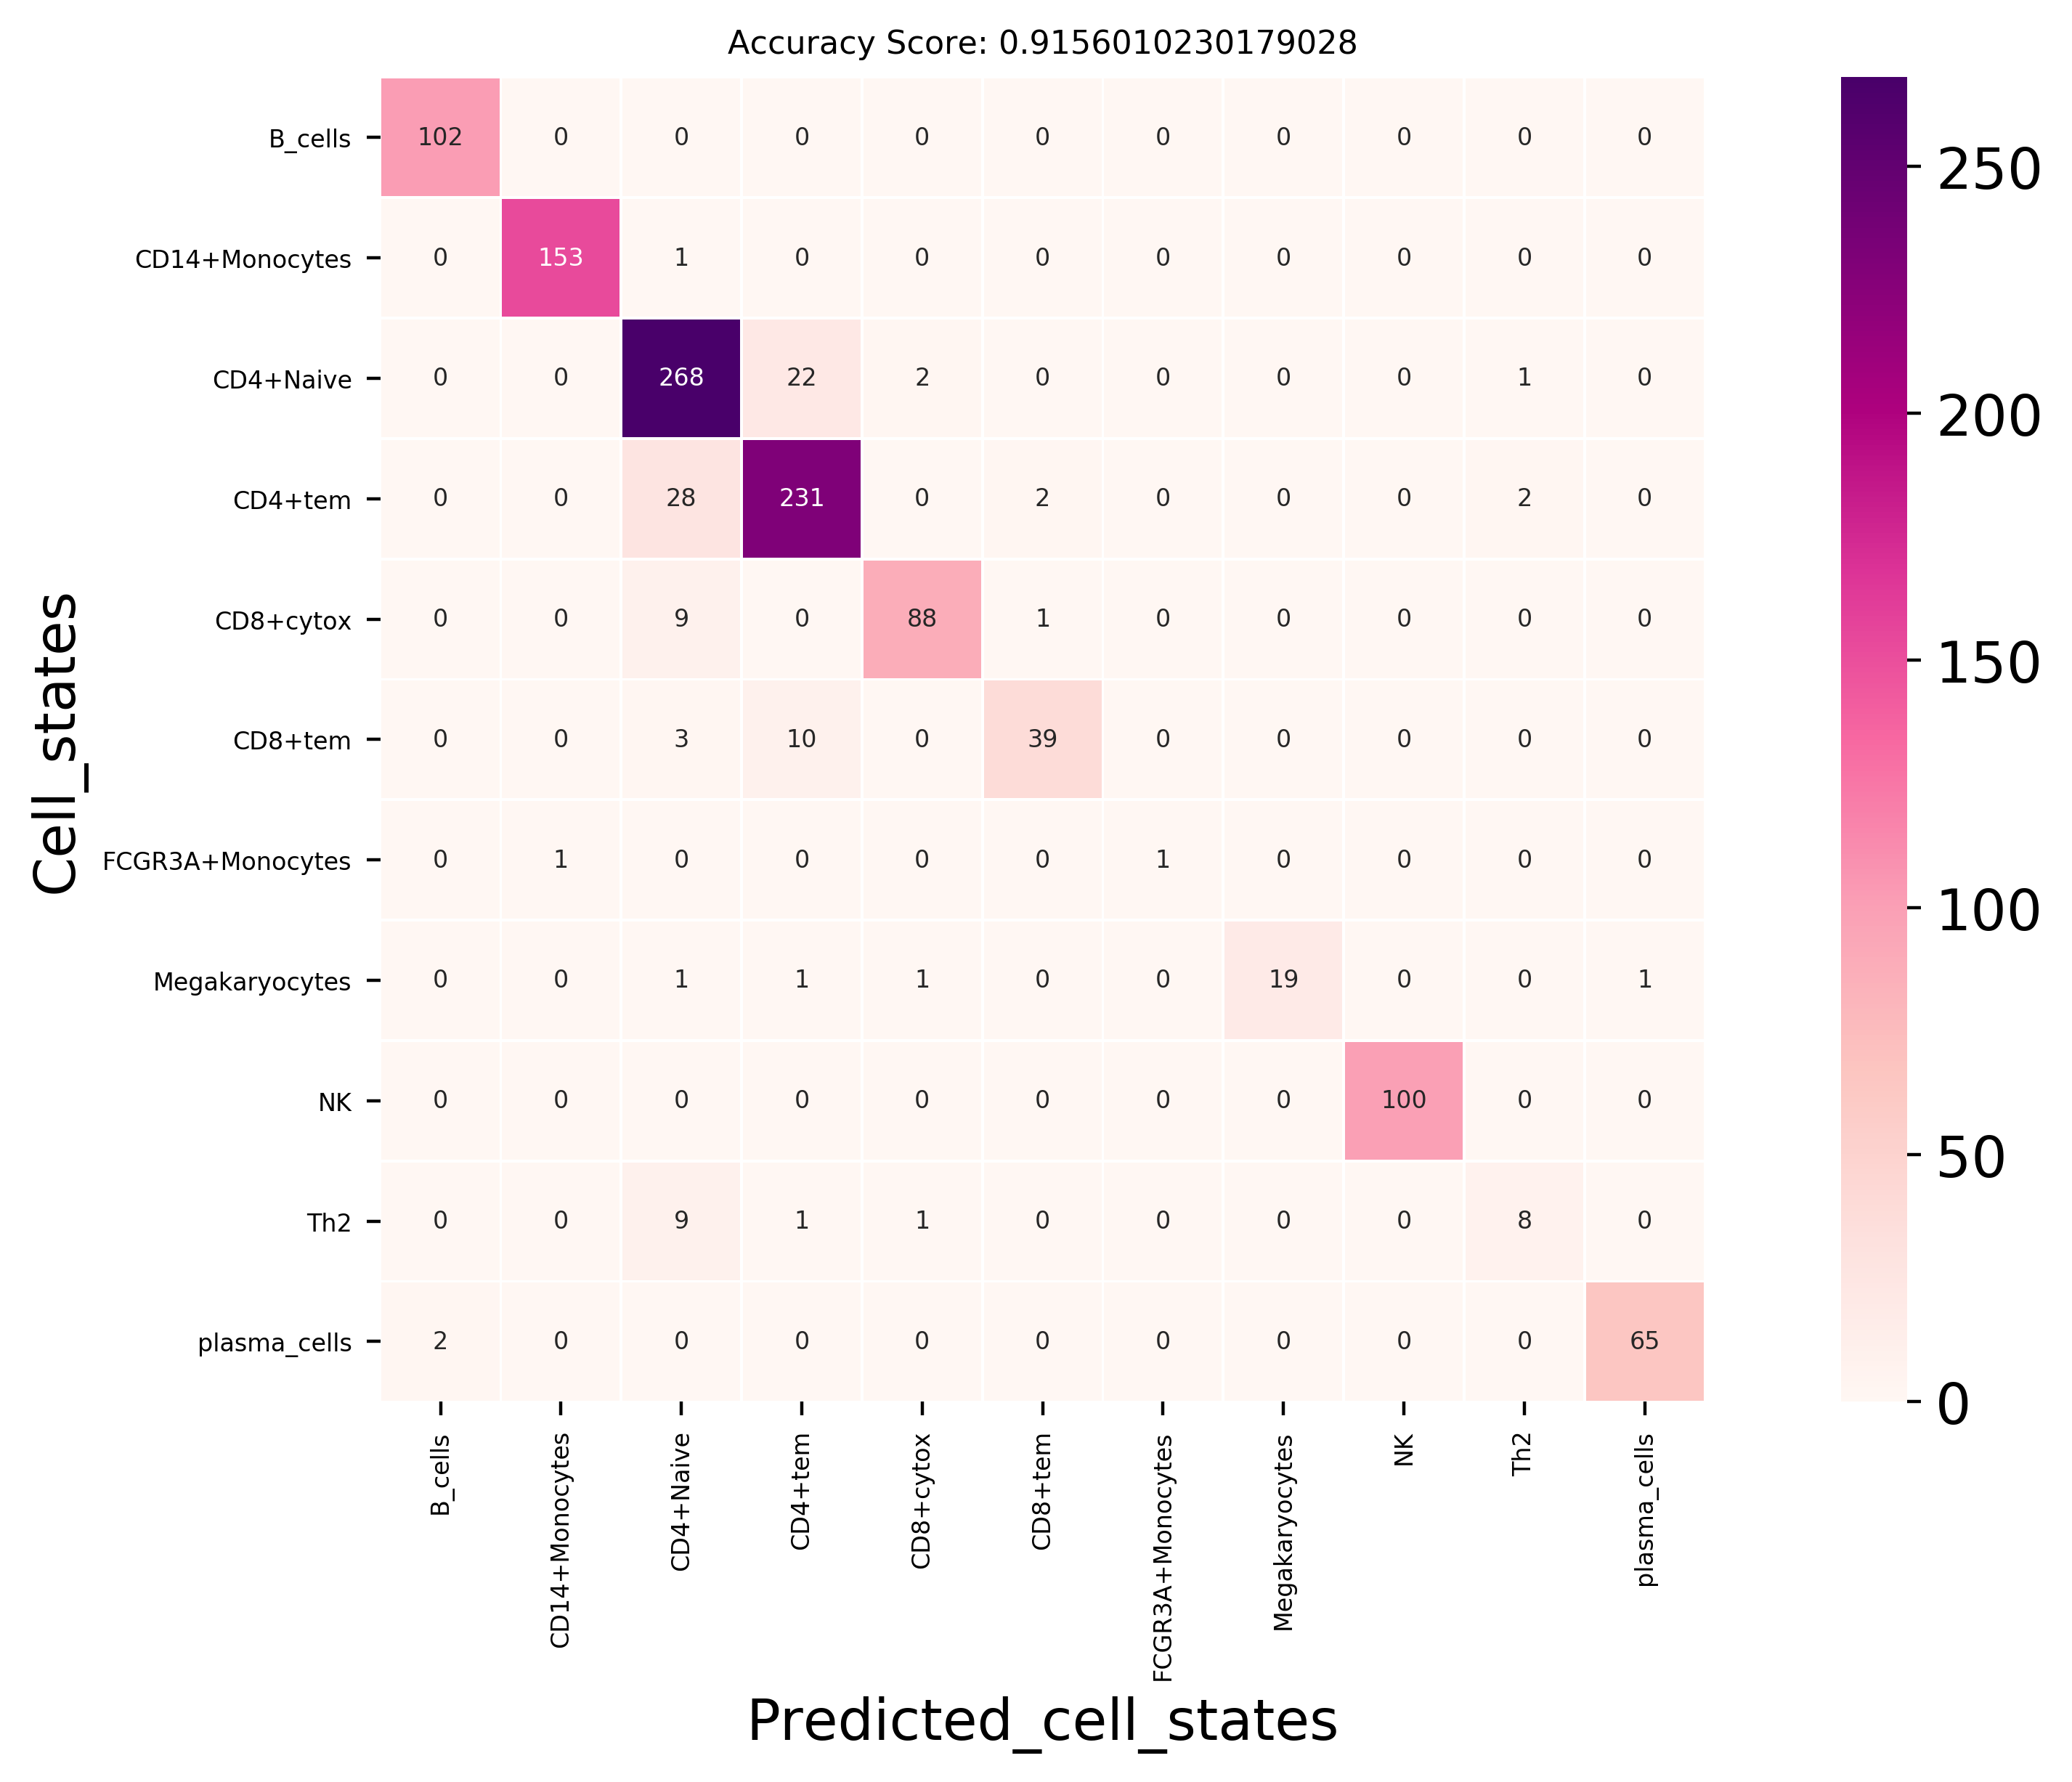

In [57]:
plt.figure(figsize = (12,6))

sns.heatmap(cm_pd, annot = True, fmt = "d", linewidths = 0.5, square = True, cmap = 'RdPu', annot_kws = {"size": 6});
plt.ylabel('Cell_states');
plt.xlabel('Predicted_cell_states');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 8);
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)

### Run predictions for Heart

In [66]:
heart = heart[heart.obs['cell_states'].isin(['CD4+T_cytox','Mast',
 'CD8+T_tem',
 'NK',
 'NKT',
 'CD8+T_cytox',
 'dpT',
 'Mo_pi',
 'CD16+Mo',
 'CD4+T_tem',
 'B_cells',
 'Mo_classic',
 'IL17RA+Mo',
 'NØ'])]

In [67]:
heart.obs['predictions'] = logisticRegr.predict(heart.X.todense())
probabilities = logisticRegr.predict_proba(heart.X.todense())
probs_heart = []
for i,clus in enumerate(heart.obs['predictions']):
    probs_heart.append(probabilities[i,logisticRegr.classes_==clus][0])
heart.obs['probabilities'] = probs_heart

Trying to set attribute `.obs` of view, copying.


In [68]:
heart.obs['predictions'].head()

AAAGTGAAGTCGGCCT-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei    CD4+tem
AAATGGAAGGTCCCTG-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei    CD4+tem
AAGACTCTCAGGACGA-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei    CD4+tem
AAGCGAGTCAAGGTGG-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei    CD4+tem
AAGTACCGTCTTACTT-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei    CD4+tem
Name: predictions, dtype: object

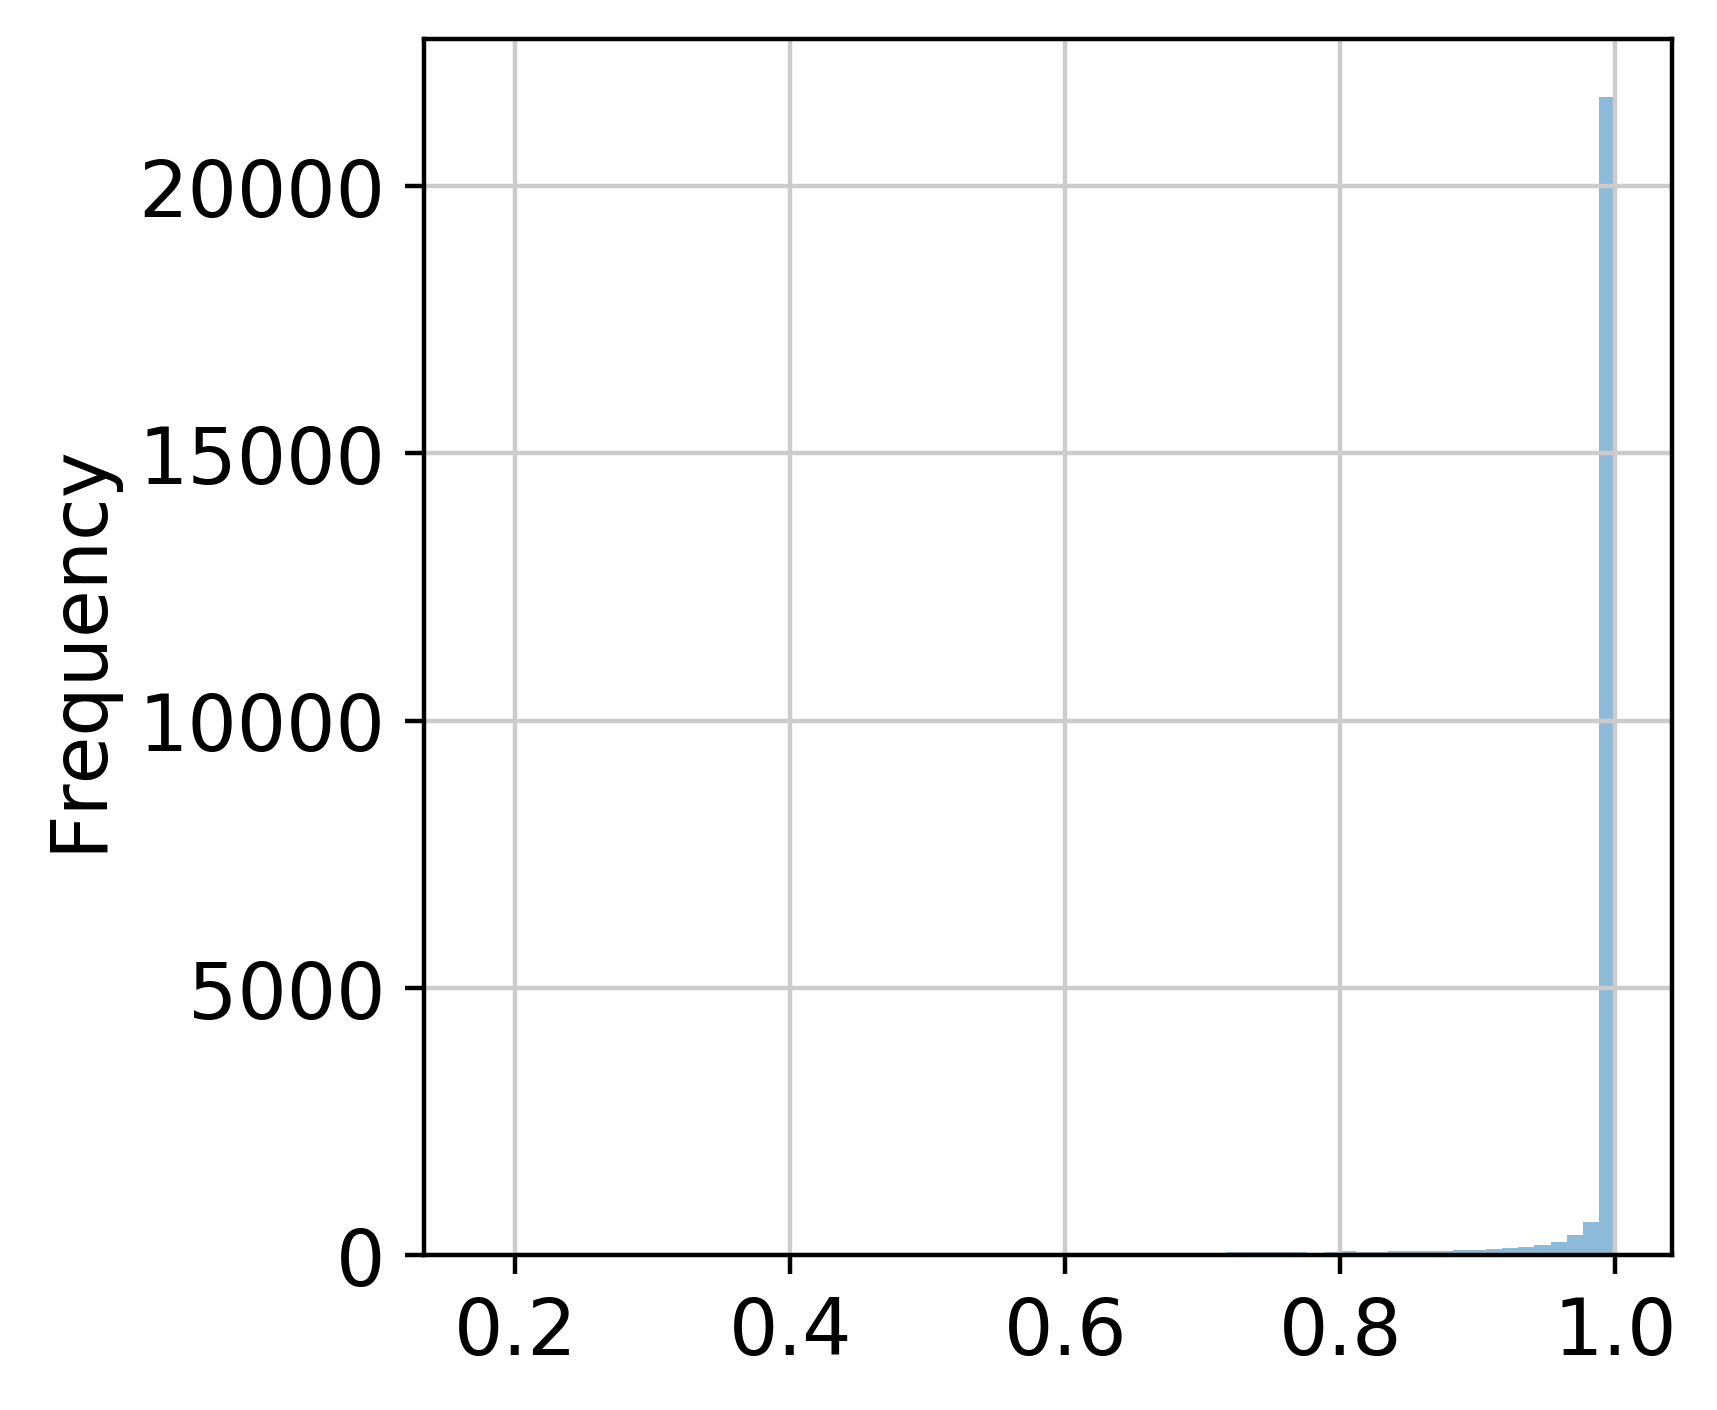

In [69]:
heart.obs['probabilities'].plot.hist(bins = 70, alpha = 0.5)

In [70]:
heart

AnnData object with n_obs × n_vars = 25726 × 33538
    obs: 'NRP', 'age_group', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'type', 'version', 'predictions', 'probabilities'
    var: 'gene_ids-Harvard-Nuclei-Harvard-Nuclei', 'feature_types-Harvard-Nuclei-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei-Harvard-Nuclei', 'feature_types-Sanger-Nuclei-Harvard-Nuclei', 'gene_ids-Sanger-Cells-Harvard-Nuclei', 'feature_types-Sanger-Cells-Harvard-Nuclei', 'gene_ids-Sanger-CD45-Harvard-Nuclei', 'feature_types-Sanger-CD45-Harvard-Nuclei', 'gene_ids-Harvard-Nuclei-Sanger-Nuclei', 'feature_types-Harvard-Nuclei-Sanger-Nuclei', 'gene_ids-Sanger-Nuclei-Sanger-Nuclei', 'feature_types-Sanger-Nuclei-Sanger-Nuclei', 'gene_ids-Sanger-Cells-Sanger-Nuclei', 'feature_types-Sanger-Cells-Sanger-Nuclei', 'gene_ids-Sanger-CD45-Sanger-Nuclei', 'feature_types-Sanger-CD45-Sanger-Nuclei', 'gene_ids-Harvard-Nuclei-Sanger-Cells',

In [71]:
heart_df = heart.obs
heart_df.head()

NRP age_group  \
AAAGTGAAGTCGGCCT-1-H0015_apex-Harvard-Nuclei-Ha...  No     50-55   
AAATGGAAGGTCCCTG-1-H0015_apex-Harvard-Nuclei-Ha...  No     50-55   
AAGACTCTCAGGACGA-1-H0015_apex-Harvard-Nuclei-Ha...  No     50-55   
AAGCGAGTCAAGGTGG-1-H0015_apex-Harvard-Nuclei-Ha...  No     50-55   
AAGTACCGTCTTACTT-1-H0015_apex-Harvard-Nuclei-Ha...  No     50-55   

                                                       cell_source  \
AAAGTGAAGTCGGCCT-1-H0015_apex-Harvard-Nuclei-Ha...  Harvard-Nuclei   
AAATGGAAGGTCCCTG-1-H0015_apex-Harvard-Nuclei-Ha...  Harvard-Nuclei   
AAGACTCTCAGGACGA-1-H0015_apex-Harvard-Nuclei-Ha...  Harvard-Nuclei   
AAGCGAGTCAAGGTGG-1-H0015_apex-Harvard-Nuclei-Ha...  Harvard-Nuclei   
AAGTACCGTCTTACTT-1-H0015_apex-Harvard-Nuclei-Ha...  Harvard-Nuclei   

                                                    cell_states donor  gender  \
AAAGTGAAGTCGGCCT-1-H0015_apex-Harvard-Nuclei-Ha...  CD4+T_cytox    H5  Female   
AAATGGAAGGTCCCTG-1-H0015_apex-Harvard-Nuclei-Ha...  CD4+T_cytox    H5  Female   
AAGACTCTCAGGACGA-1-H0015_apex-Harvard-Nuclei-Ha...         Mast    H5  Female   
AAGCGAGTCAAGGTGG-1-H0015_apex-Harvard-Nuclei-Ha...         Mast    H5  Female   
AAGTACCGTCTTACTT-1-H0015_apex-Harvard-Nuclei-Ha...         Mast    H5  Female   

                                                    n_counts  n_genes  \
AAAGTGAAGTCGGCCT-1-H0015_apex-Harvard-Nuclei-Ha...     724.0      588   
AAATGGAAGGTCCCTG-1-H0015_apex-Harvard-Nuclei-Ha...     636.0      515   
AAGACTCTCAGGACGA-1-H0015_apex-Harvard-Nuclei-Ha...     545.0      428   
AAGCGAGTCAAGGTGG-1-H0015_apex-Harvard-Nuclei-Ha...     503.0      401   
AAGTACCGTCTTACTT-1-H0015_apex-Harvard-Nuclei-Ha...     736.0      563   

                                                    percent_mito  \
AAAGTGAAGTCGGCCT-1-H0015_apex-Harvard-Nuclei-Ha...      0.023481   
AAATGGAAGGTCCCTG-1-H0015_apex-Harvard-Nuclei-Ha...      0.006289   
AAGACTCTCAGGACGA-1-H0015_apex-Harvard-Nuclei-Ha...      0.001835   
AAGCGAGTCAAGGTGG-1-H0015_apex-Harvard-Nuclei-Ha...      0.001988   
AAGTACCGTCTTACTT-1-H0015_apex-Harvard-Nuclei-Ha...      0.001359   

                                                    percent_ribo region  \
AAAGTGAAGTCGGCCT-1-H0015_apex-Harvard-Nuclei-Ha...      0.001381     AX   
AAATGGAAGGTCCCTG-1-H0015_apex-Harvard-Nuclei-Ha...      0.001572     AX   
AAGACTCTCAGGACGA-1-H0015_apex-Harvard-Nuclei-Ha...      0.005505     AX   
AAGCGAGTCAAGGTGG-1-H0015_apex-Harvard-Nuclei-Ha...      0.000000     AX   
AAGTACCGTCTTACTT-1-H0015_apex-Harvard-Nuclei-Ha...      0.004076     AX   

                                                        sample  \
AAAGTGAAGTCGGCCT-1-H0015_apex-Harvard-Nuclei-Ha...  H0015_apex   
AAATGGAAGGTCCCTG-1-H0015_apex-Harvard-Nuclei-Ha...  H0015_apex   
AAGACTCTCAGGACGA-1-H0015_apex-Harvard-Nuclei-Ha...  H0015_apex   
AAGCGAGTCAAGGTGG-1-H0015_apex-Harvard-Nuclei-Ha...  H0015_apex   
AAGTACCGTCTTACTT-1-H0015_apex-Harvard-Nuclei-Ha...  H0015_apex   

                                                    scrublet_score type  \
AAAGTGAAGTCGGCCT-1-H0015_apex-Harvard-Nuclei-Ha...        0.026029  DBD   
AAATGGAAGGTCCCTG-1-H0015_apex-Harvard-Nuclei-Ha...        0.074830  DBD   
AAGACTCTCAGGACGA-1-H0015_apex-Harvard-Nuclei-Ha...        0.048649  DBD   
AAGCGAGTCAAGGTGG-1-H0015_apex-Harvard-Nuclei-Ha...        0.034355  DBD   
AAGTACCGTCTTACTT-1-H0015_apex-Harvard-Nuclei-Ha...        0.014286  DBD   

                                                   version predictions  \
AAAGTGAAGTCGGCCT-1-H0015_apex-Harvard-Nuclei-Ha...      V3     CD4+tem   
AAATGGAAGGTCCCTG-1-H0015_apex-Harvard-Nuclei-Ha...      V3     CD4+tem   
AAGACTCTCAGGACGA-1-H0015_apex-Harvard-Nuclei-Ha...      V3     CD4+tem   
AAGCGAGTCAAGGTGG-1-H0015_apex-Harvard-Nuclei-Ha...      V3     CD4+tem   
AAGTACCGTCTTACTT-1-H0015_apex-Harvard-Nuclei-Ha...      V3     CD4+tem   

                                                    probabilities  
AAAGTGAAGTCGGCCT-1-H0015_apex-Harvard-Nuclei-Ha...       0.987158  
AAATGG

In [72]:
heart_sig = heart_df[heart_df['probabilities'] > 0.8]
heart_sig.shape

(24176, 17)

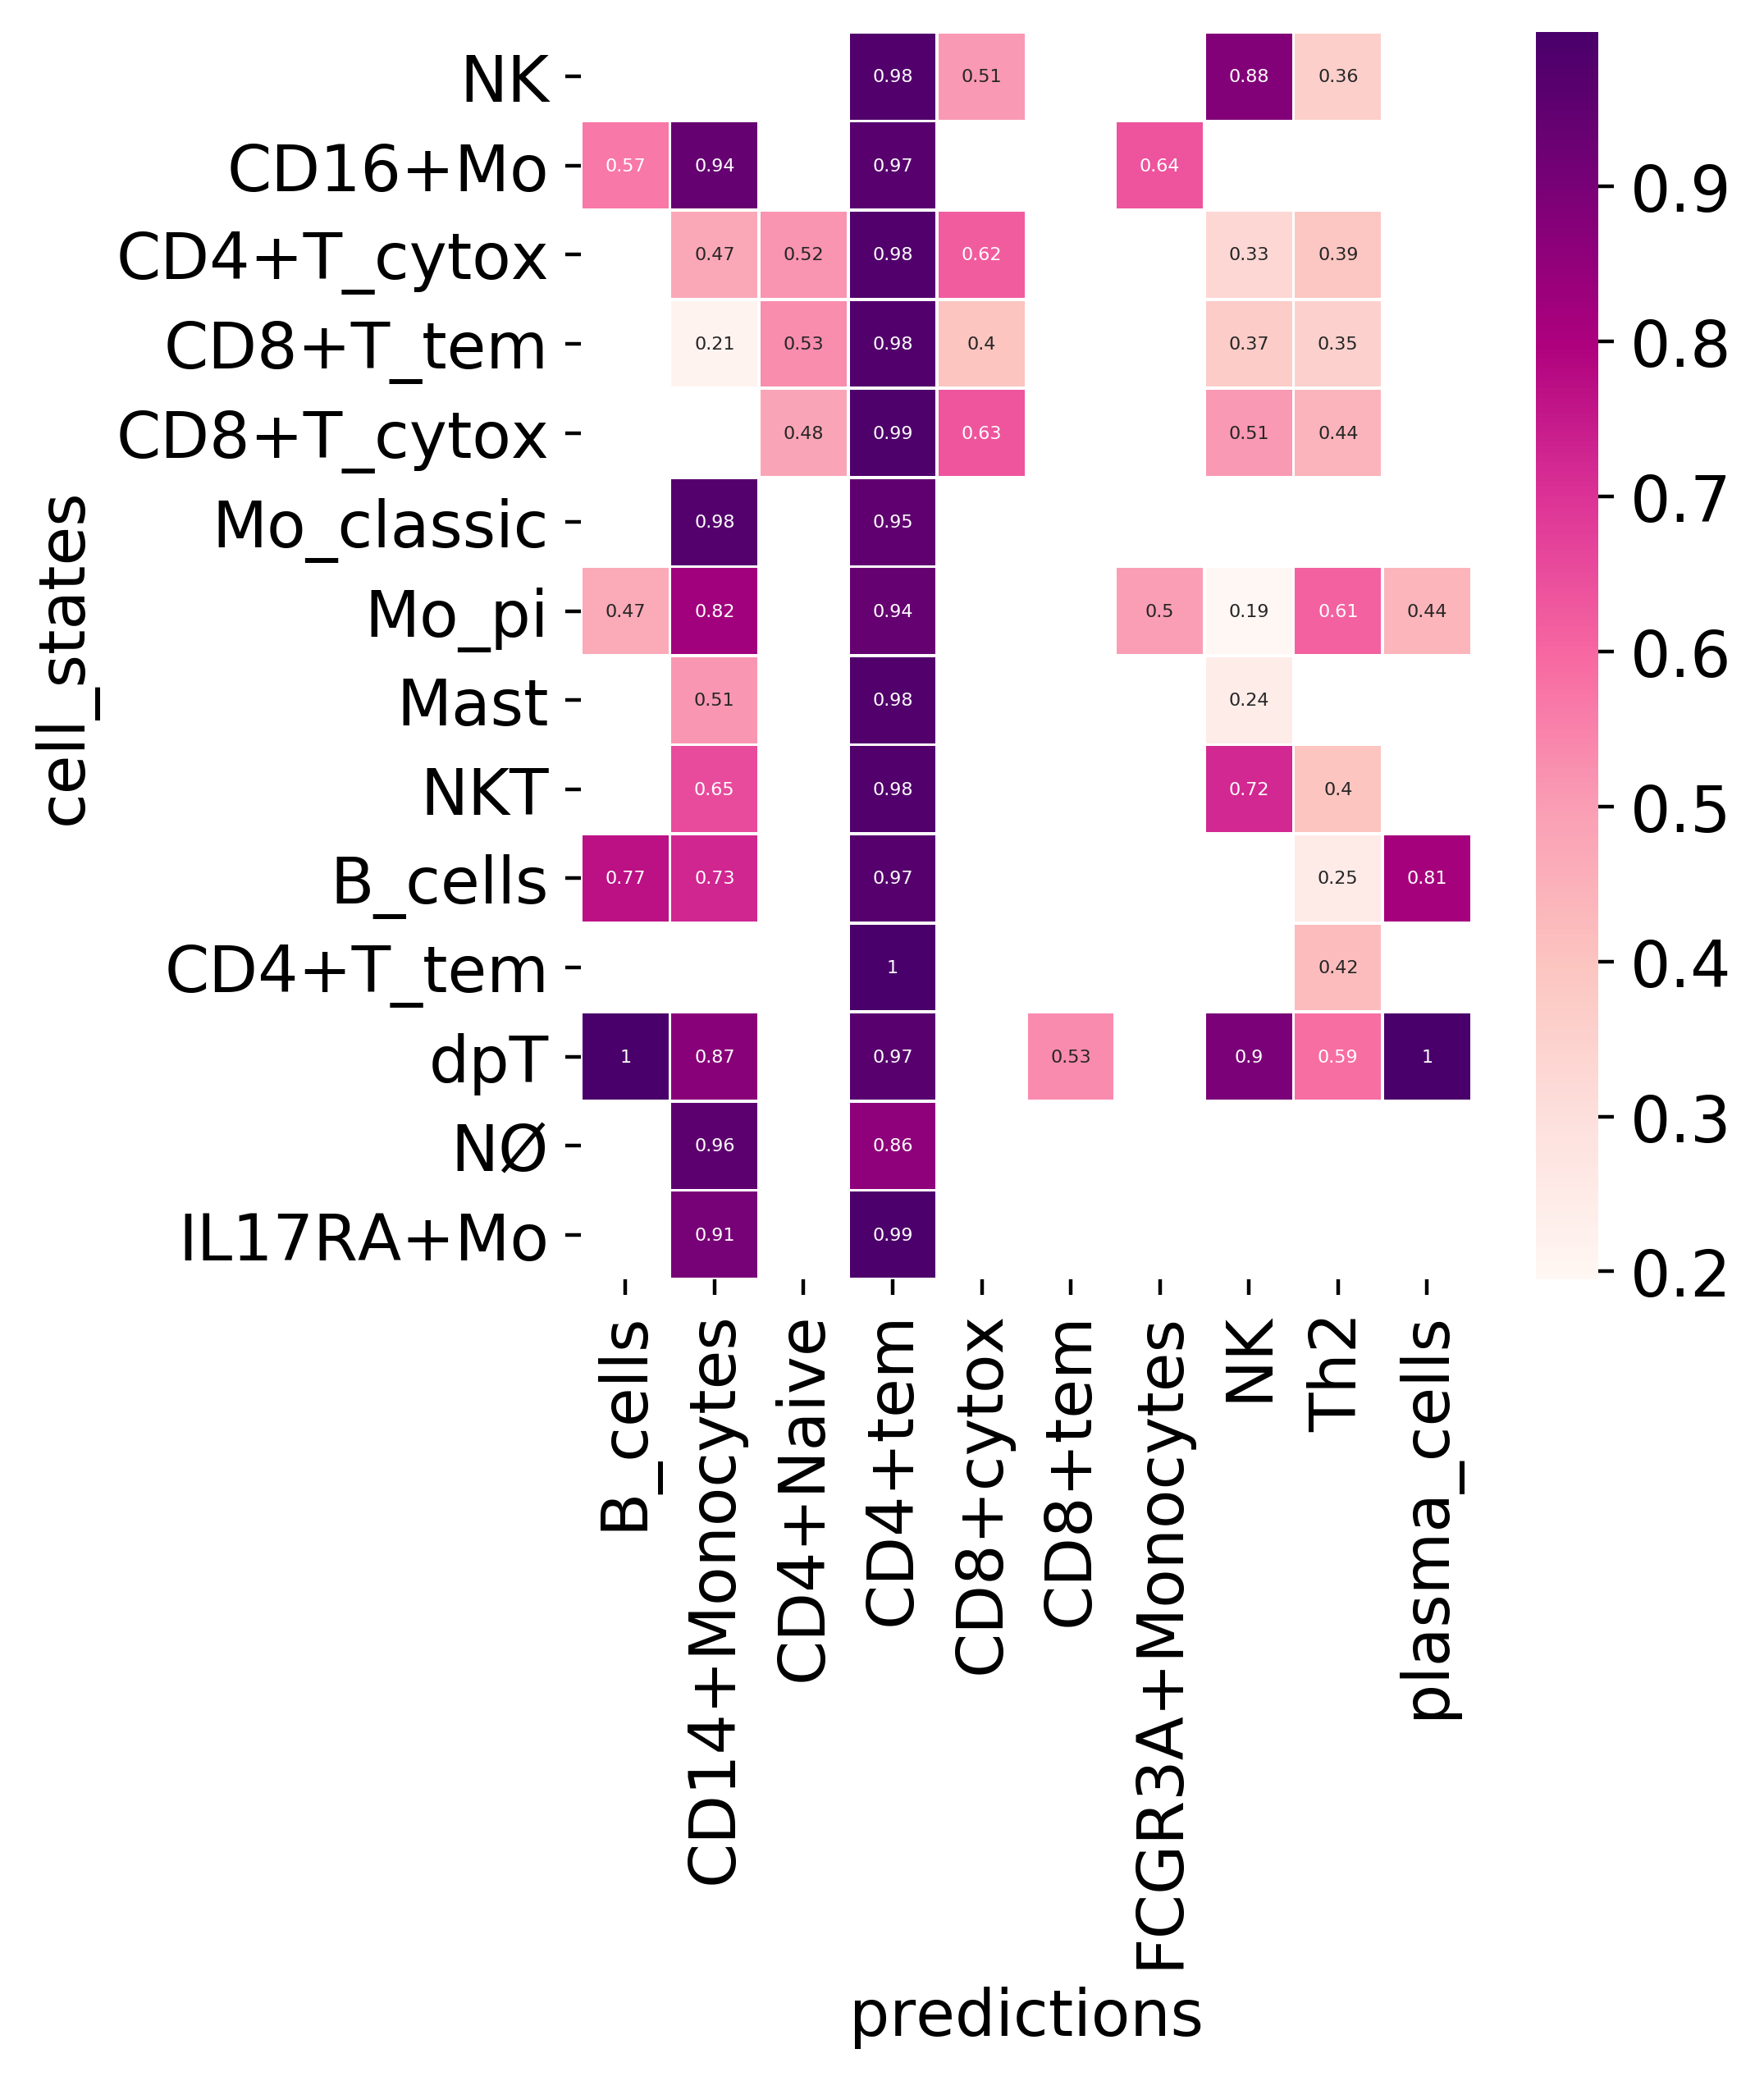

In [74]:
plt.figure(figsize = (5,5))
df_heatmap = heart_df.pivot_table(values = 'probabilities', index = 'cell_states', columns = 'predictions', aggfunc = np.mean)
sns.heatmap(df_heatmap, annot = True, linewidths = 0.5, square = True, cmap = 'RdPu', annot_kws = {"size": 4})
plt.show()

In [ ]:
plt.figure(figsize = (12,6))

sns.heatmap(cm_pd, annot = True, fmt = "d", linewidths = 0.5, square = True, cmap = 'RdPu', annot_kws = {"size": 6});
plt.ylabel('Cell_states');
plt.xlabel('Predicted_cell_states');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 8);
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)

### Select cells with higher probability 

In [ ]:
heart_sig = heart[heart.obs['probabilities'] > 0.8]
heart_sig.shape

In [ ]:
heart_sig.obs['predictions'] = heart_sig.obs['predictions'].astype('category')
heart_sig.obs['predictions'].cat.categories

### Merge datasets

In [ ]:
tissues = blood.concatenate(heart_sig, batch_key = 'tissues', batch_categories = ['blood', 'heart'], join = 'inner')
pd.crosstab(tissues.obs['predictions'], tissues.obs['tissues'])

In [ ]:
HKM.write('/home/jovyan/experiments/9-comparative_analyses/immune_skm_heart_kidney/HCA_Heart_SKM_Kidney_RAW_inner_ctl200530_log.h5ad')